In [106]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import time

In [107]:
import numpy as np
import pandas as pd

In [108]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [109]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [110]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [111]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [112]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [113]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [114]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [115]:
#Find the last date in the data
maxDate = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
tempValMaxDate = list(np.ravel(maxDate))[0]
tempValMaxDate = dt.datetime.strptime(tempValMaxDate, '%Y-%m-%d')


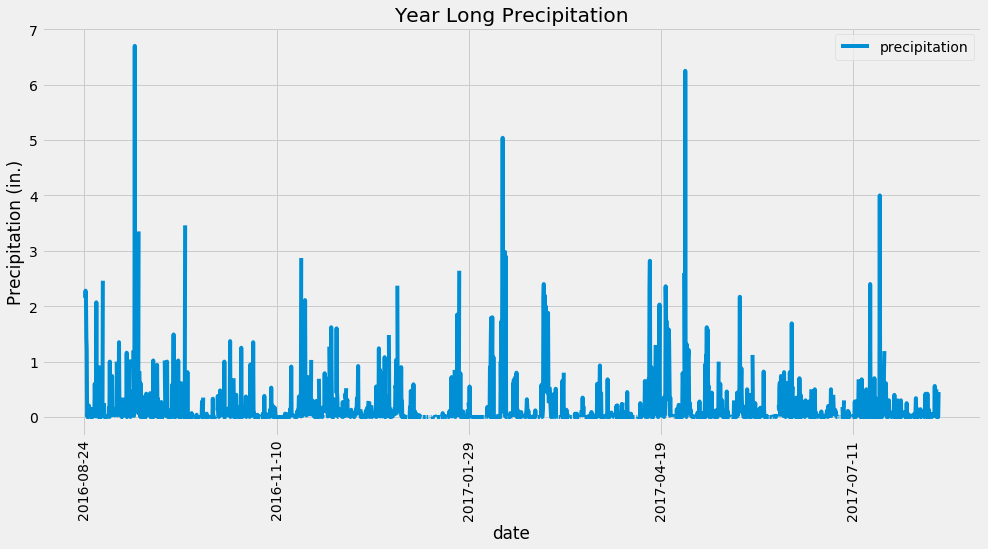

In [116]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
yearAgo = tempValMaxDate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rainQuery = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= yearAgo).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rainQuery, columns = ['date', 'precipitation'])

#rain_df = pd.DataFrame(rainQuery)
rain_df.set_index('date', inplace=True)

# Sort the dataframe by date
rain_df = rain_df.sort_index(ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
rain_df.plot(ax = ax, rot=90)
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig('Images/precipitation.png')
#plt.tight_layout()
plt.show()

In [117]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [118]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).count()
print(f"There are {stations} stations available.")

There are 9 stations available.


In [119]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

print(stations)

#Most Active Station
stationID = stations[0][0]
print(f"\n The most active staion {stationID}.")

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

 The most active staion USC00519281.


In [120]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == stationID).all()
temperature

[(54.0, 85.0, 71.66378066378067)]

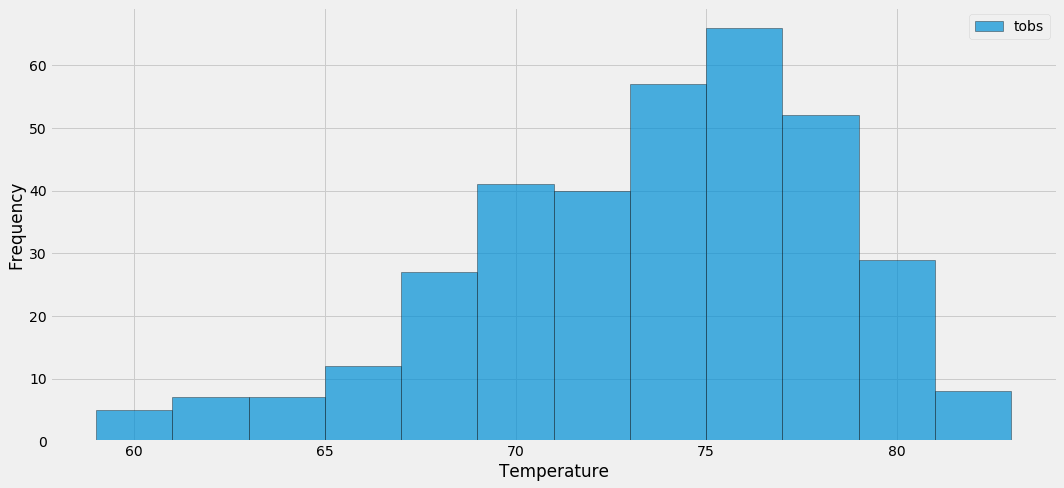

In [121]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempObservation = session.query(Measurement.date, Measurement.tobs).\
                            filter(Measurement.station == stationID).\
                            filter(func.strftime("%Y-%m-%d", Measurement.date) >= yearAgo).all()


tempObservation_df = pd.DataFrame(tempObservation)

fig, ax = plt.subplots(figsize = (15,7))
tempObservation_df.plot.hist(bins = 12, ax = ax, alpha=.7, edgecolor='black')
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')


plt.savefig("Images/yearlyHist.png")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [122]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [123]:
#Stringafy my dates to pass through calc_temps function
stringMaxDate = dt.datetime.strftime(tempValMaxDate, '%Y-%m-%d')
stringMinDate = dt.datetime.strftime(yearAgo, '%Y-%m-%d')
print(stringMinDate,stringMaxDate)

2016-08-23 2017-08-23


In [124]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripTemperature = calc_temps(stringMinDate, stringMaxDate)
tripTemperature

[(58.0, 74.59058295964125, 87.0)]

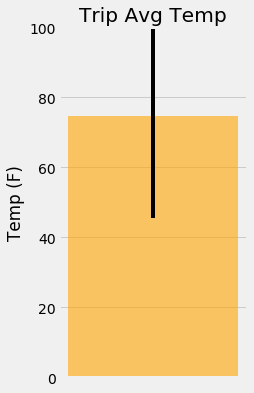

In [125]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
minTemp = tripTemperature[0][0]
maxTemp = tripTemperature[0][2]
avgTemp = tripTemperature[0][1]

#minError = avgTemp - minTemp
#maxError = maxTemp - avgTemp

plt.figure(figsize=(3,6))
plt.bar(0, avgTemp, yerr=[maxTemp-minTemp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.savefig("Images/avgTemp.png")
plt.show()



In [126]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

tempRain = session.query(Station.station, func.sum(Measurement.prcp), Station.name, Station.elevation, Station.latitude, Station.longitude).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= stringMinDate).\
                    filter(Measurement.date <= stringMaxDate).\
                    group_by(Station.station).\
                    order_by(func.sum(Measurement.prcp).desc())

for row in tempRain:
    rain="{0:.2f}".format(row[1])
    print (f"Station:{row[0]}\n Rainfall:{rain}\n Location:{row[2]}\n Elevation:{row[3]} Latitude:{row[4]} Longitude:{row[5]}\n")
  

Station:USC00516128
 Rainfall:147.81
 Location:MANOA LYON ARBO 785.2, HI US
 Elevation:152.4 Latitude:21.3331 Longitude:-157.8025

Station:USC00519281
 Rainfall:70.03
 Location:WAIHEE 837.5, HI US
 Elevation:32.9 Latitude:21.45167 Longitude:-157.84888999999998

Station:USC00513117
 Rainfall:48.51
 Location:KANEOHE 838.1, HI US
 Elevation:14.6 Latitude:21.4234 Longitude:-157.8015

Station:USC00519523
 Rainfall:38.01
 Location:WAIMANALO EXPERIMENTAL FARM, HI US
 Elevation:19.5 Latitude:21.33556 Longitude:-157.71139

Station:USC00514830
 Rainfall:33.24
 Location:KUALOA RANCH HEADQUARTERS 886.9, HI US
 Elevation:7.0 Latitude:21.5213 Longitude:-157.8374

Station:USC00519397
 Rainfall:16.09
 Location:WAIKIKI 717.2, HI US
 Elevation:3.0 Latitude:21.2716 Longitude:-157.8168

Station:USC00517948
 Rainfall:4.59
 Location:PEARL CITY, HI US
 Elevation:11.9 Latitude:21.3934 Longitude:-157.9751



In [127]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [148]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
startDate2 = time.mktime(dt.datetime.strptime(stringMinDate, "%Y-%m-%d").timetuple())
endDate2 = time.mktime(dt.datetime.strptime(stringMaxDate, "%Y-%m-%d").timetuple())
conversionSecDay = 86400

tripInterval = (endDate2 - startDate2)/conversionSecDay

startDate = dt.datetime.strptime(stringMinDate, '%Y-%m-%d')
# Stip off the year and save a list of %m-%d strings

dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, int(tripInterval))]

# Loop through the list of %m-%d strings and calculate the normals for each date
tripNormals = [daily_normals(date) for date in dateList]
tripNormals

[[(67.0, 76.6923076923077, 87.0)],
 [(70.0, 75.96153846153847, 84.0)],
 [(69.0, 76.96078431372548, 82.0)],
 [(71.0, 76.56862745098039, 84.0)],
 [(68.0, 76.28301886792453, 84.0)],
 [(67.0, 76.73469387755102, 86.0)],
 [(70.0, 76.23529411764706, 85.0)],
 [(68.0, 76.41666666666667, 84.0)],
 [(67.0, 76.84, 85.0)],
 [(69.0, 77.0, 82.0)],
 [(67.0, 76.66666666666667, 83.0)],
 [(69.0, 76.13725490196079, 83.0)],
 [(68.0, 76.27083333333333, 84.0)],
 [(66.0, 75.91489361702128, 84.0)],
 [(66.0, 74.91111111111111, 81.0)],
 [(64.0, 75.18, 82.0)],
 [(66.0, 76.22222222222223, 83.0)],
 [(68.0, 76.36538461538461, 84.0)],
 [(67.0, 76.61224489795919, 85.0)],
 [(70.0, 76.69565217391305, 83.0)],
 [(68.0, 75.89795918367346, 85.0)],
 [(68.0, 75.875, 82.0)],
 [(69.0, 75.98076923076923, 85.0)],
 [(67.0, 76.14, 81.0)],
 [(70.0, 77.40384615384616, 86.0)],
 [(68.0, 76.57692307692308, 83.0)],
 [(67.0, 75.85106382978724, 84.0)],
 [(68.0, 76.34693877551021, 87.0)],
 [(69.0, 76.14583333333333, 83.0)],
 [(67.0, 76.44897

In [149]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#Separate Tuple and then create a Datagrame from separated values
tripNormals = [np.array(normal[0]) for normal in tripNormals]
normal_df = pd.DataFrame(tripNormals)
normal_df["Date"] = dateList
normal_df = normal_df.set_index("Date")
normal_df = normal_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
normal_df

,Low Temp,Avg Temp,High Temp
Date,,,
08-23,67.0,76.692308,87.0
08-24,70.0,75.961538,84.0
08-25,69.0,76.960784,82.0
08-26,71.0,76.568627,84.0
08-27,68.0,76.283019,84.0
...,...,...,...
08-18,70.0,76.923077,84.0
08-19,69.0,75.946429,85.0
08-20,68.0,76.452830,82.0


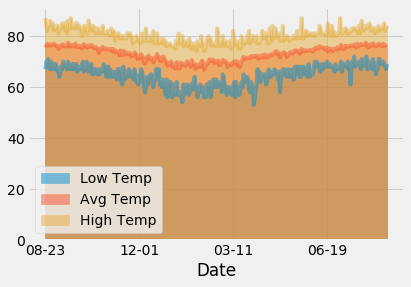

In [150]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False, alpha=.5)
plt.savefig("Images/stacked.png")